In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=(window_size,)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model.summary()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 6s 187ms/step - loss: 21.4956 - mae: 22.0115
Epoch 2/100
31/31 [=

[1e-08, 0.0001, 0, 30]

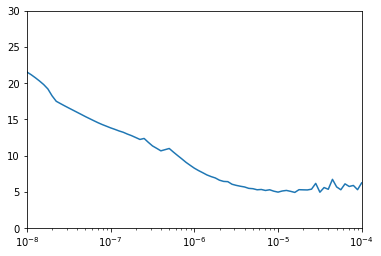

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
model.summary()
history = model.fit(dataset,epochs=500,verbose=2)

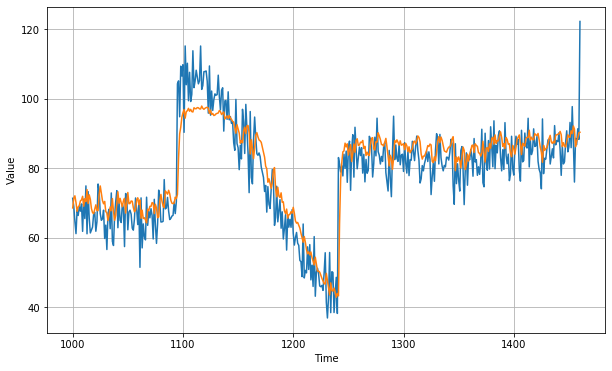

In [9]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.736518

<Figure size 432x288 with 0 Axes>

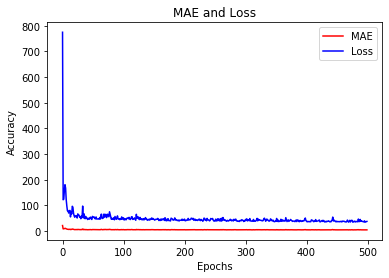

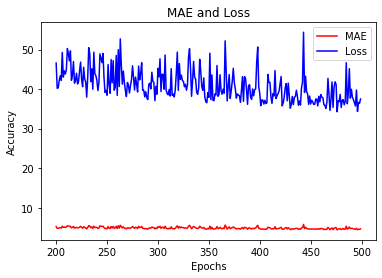

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [12]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=2)

Epoch 1/100
31/31 - 4s - loss: 731.2876
Epoch 2/100
31/31 - 1s - loss: 109.0233
Epoch 3/100
31/31 - 0s - loss: 74.1172
Epoch 4/100
31/31 - 0s - loss: 66.8781
Epoch 5/100
31/31 - 0s - loss: 63.3581
Epoch 6/100
31/31 - 0s - loss: 60.8342
Epoch 7/100
31/31 - 0s - loss: 57.4510
Epoch 8/100
31/31 - 0s - loss: 60.9661
Epoch 9/100
31/31 - 0s - loss: 50.7552
Epoch 10/100
31/31 - 0s - loss: 50.1034
Epoch 11/100
31/31 - 0s - loss: 50.9633
Epoch 12/100
31/31 - 0s - loss: 53.5146
Epoch 13/100
31/31 - 0s - loss: 53.1071
Epoch 14/100
31/31 - 0s - loss: 48.7203
Epoch 15/100
31/31 - 0s - loss: 49.4865
Epoch 16/100
31/31 - 0s - loss: 50.9194
Epoch 17/100
31/31 - 0s - loss: 52.4292
Epoch 18/100
31/31 - 0s - loss: 49.7048
Epoch 19/100
31/31 - 0s - loss: 48.8730
Epoch 20/100
31/31 - 0s - loss: 52.3074
Epoch 21/100
31/31 - 0s - loss: 52.9675
Epoch 22/100
31/31 - 0s - loss: 48.6843
Epoch 23/100
31/31 - 0s - loss: 46.8713
Epoch 24/100
31/31 - 0s - loss: 48.9688
Epoch 25/100
31/31 - 0s - loss: 46.9184
Epoch 2

In [13]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 7s 221ms/step - loss: 749.0701
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 151.6538
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 97.3706
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 83.0466
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 78.1885
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 73.3087
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 67.6801
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 74.6161
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 72.8730
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 63.0269
Epoch 11/100
31/31 [==============================] - 1s 20ms/step - loss: 60.8493
Epoch 12/100
31/31 [==============================] - 1s 20ms/step - loss: 57.8943
Epoch 13/1

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.736518